**Image Restoration:**

*   Wiener filter;
*   Least Square filter.




- Bibliotecas Usadas

In [164]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
import cv2
from skimage import color, data, measure, restoration

- Funções Implementadas

In [165]:

# Cria uma matriz com os pixels para o efeito de desfoque do movimento
def getMotionDsf(shape, angle, dist):
  xCenter = (shape[0] - 1) / 2
  yCenter = (shape[1] - 1) / 2
  sinVal = np.sin(angle * np.pi / 180)
  cosVal = np.cos(angle * np.pi / 180)
  PSF = np.zeros(shape)  #  point spread function 
  for i in range(dist):  #  Put the corresponding angle motion_dis Point setting 1
    xOffset = round(sinVal * i)
    yOffset = round(cosVal * i)
    PSF[int(xCenter - xOffset), int(yCenter + yOffset)] = 1
  return PSF / PSF.sum()  #  normalization 

# Faz a convolução da imagem com a matriz de efeito de desfoque do movimento(PSF)
def makeBlurred(image, PSF, eps):  #  Motion blur the picture 
  fftImg = np.fft.fft2(image)  #  Fourier transform of two-dimensional array 
  fftPSF = np.fft.fft2(PSF) + eps
  fftBlur = np.fft.ifft2(fftImg * fftPSF)
  fftBlur = np.abs(np.fft.fftshift(fftBlur))
  return fftBlur

# Filtro de Wiener
def wienerFilter(input, PSF, eps, K=0.01):  #  Wiener filtering ,K=0.01
  fftImg = np.fft.fft2(input)
  fftPSF = np.fft.fft2(PSF) + eps
  fftWiener = np.conj(fftPSF) / (np.abs(fftPSF)**2 + K)
  imgWienerFilter = np.fft.ifft2(fftImg * fftWiener)
  imgWienerFilter = np.abs(np.fft.fftshift(imgWienerFilter))
  return imgWienerFilter

def getPuv(image):
  h, w = image.shape[:2]
  hPad, wPad = h - 3, w - 3
  pxy = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
  pxyPad = np.pad(pxy, ((hPad//2, hPad - hPad//2), (wPad//2, wPad - wPad//2)), mode='constant')
  fftPuv = np.fft.fft2(pxyPad)
  return fftPuv

# Filtro de mínimos quadrados
def leastSquareFilter(image, PSF, eps, gamma=0.01):  #  Constrained least squares filtering 
  fftImg = np.fft.fft2(image)
  fftPSF = np.fft.fft2(PSF)
  conj = fftPSF.conj()
  fftPuv = getPuv(image)
  Huv = conj / (np.abs(fftPSF)**2 + gamma * (np.abs(fftPuv)**2))
  ifftImg = np.fft.ifft2(fftImg * Huv)
  ifftShift = np.abs(np.fft.fftshift(ifftImg))
  imgLSFilter = np.uint8(cv2.normalize(np.abs(ifftShift), None, 0, 255, cv2.NORM_MINMAX))  #  Owned by one becomes  [0,255]
  return imgLSFilter

- Preparação da Imagem

In [166]:
# Ler a imagem da lena em escala de cinza
img = cv2.imread("lena.jpg",0)
hImg, wImg = img.shape[:2]

#  Cria a matriz de efeito de desfoque do movimento(PSF) e cria a imagem desfocada sem ruído
PSF = getMotionDsf((hImg, wImg), 45, 100)   
imgBlurred = np.abs(makeBlurred(img, PSF, 1e-6))  

#  Adiciona ruído gaussiano à imagem desfocada
scale = 0.1  #  desvio padrao da distribuicao normal
noisy = imgBlurred.std() * np.random.normal(loc=0.0, scale=scale, size=imgBlurred.shape)  
imgBlurNoisy = imgBlurred + noisy  

- Aplicação da Imagem ao filtro

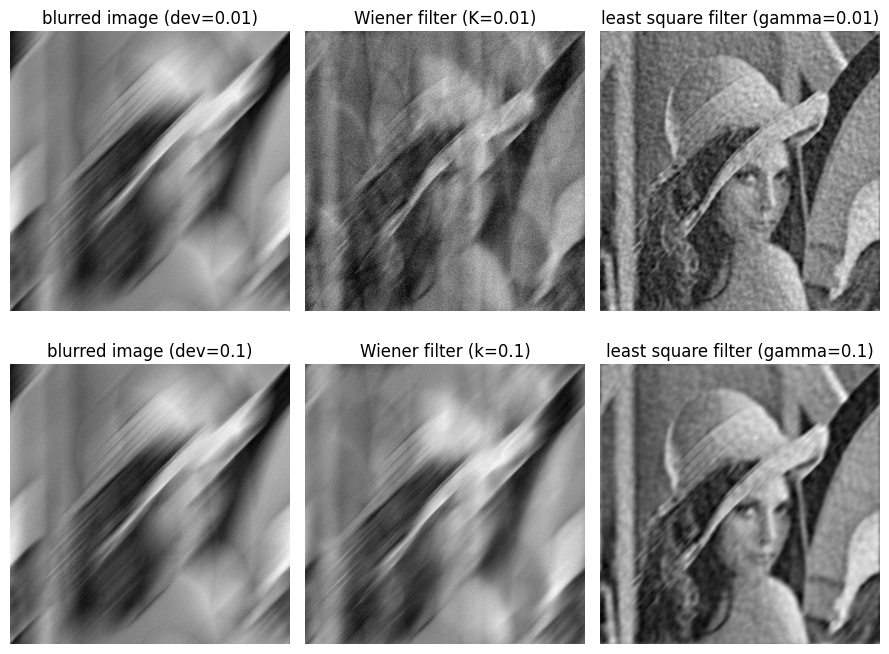

In [167]:
imgWienerFilter = wienerFilter(imgBlurNoisy, PSF, scale, K=0.01)  
imgLSFilter = leastSquareFilter(imgBlurNoisy, PSF, scale, gamma=0.01)  

plt.figure(figsize=(9, 7))
plt.subplot(231), plt.title("blurred image (dev=0.01)"), plt.axis('off'), plt.imshow(imgBlurNoisy, 'gray')
plt.subplot(232), plt.title("Wiener filter (K=0.01)"), plt.axis('off'), plt.imshow(imgWienerFilter, 'gray')
plt.subplot(233), plt.title("least square filter (gamma=0.01)"), plt.axis('off'), plt.imshow(imgLSFilter, 'gray')


imgWienerFilter = wienerFilter(imgBlurNoisy, PSF, scale, K=0.1)  #  Wiener filtering 
imgLSFilter = leastSquareFilter(imgBlurNoisy, PSF, scale, gamma=0.1)  #  Constrained least squares filtering 

plt.subplot(234), plt.title("blurred image (dev=0.1)"), plt.axis('off'), plt.imshow(imgBlurNoisy, 'gray')
plt.subplot(235), plt.title("Wiener filter (k=0.1)"), plt.axis('off'), plt.imshow(imgWienerFilter, 'gray')
plt.subplot(236), plt.title("least square filter (gamma=0.1)"), plt.axis('off'), plt.imshow(imgLSFilter, 'gray')
plt.tight_layout()
plt.show()

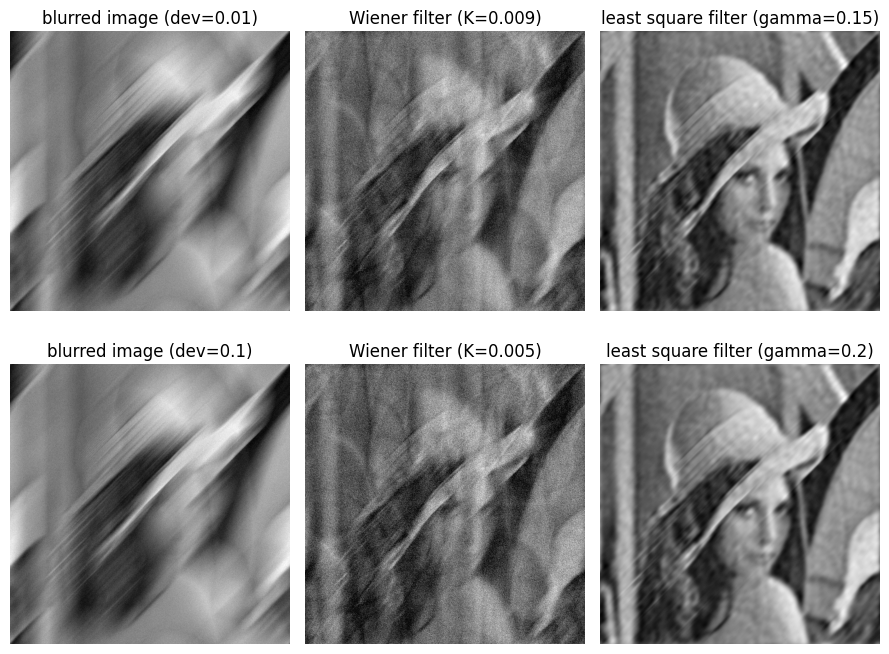

In [168]:
imgWienerFilter = wienerFilter(imgBlurNoisy, PSF, scale, K=0.009)  
imgLSFilter = leastSquareFilter(imgBlurNoisy, PSF, scale, gamma=0.15)  

plt.figure(figsize=(9, 7))
plt.subplot(231), plt.title("blurred image (dev=0.01)"), plt.axis('off'), plt.imshow(imgBlurNoisy, 'gray')
plt.subplot(232), plt.title("Wiener filter (K=0.009)"), plt.axis('off'), plt.imshow(imgWienerFilter, 'gray')
plt.subplot(233), plt.title("least square filter (gamma=0.15)"), plt.axis('off'), plt.imshow(imgLSFilter, 'gray')


imgWienerFilter = wienerFilter(imgBlurNoisy, PSF, scale, K=0.005)  #  Wiener filtering 
imgLSFilter = leastSquareFilter(imgBlurNoisy, PSF, scale, gamma=0.2)  #  Constrained least squares filtering 

plt.subplot(234), plt.title("blurred image (dev=0.1)"), plt.axis('off'), plt.imshow(imgBlurNoisy, 'gray')
plt.subplot(235), plt.title("Wiener filter (K=0.005)"), plt.axis('off'), plt.imshow(imgWienerFilter, 'gray')
plt.subplot(236), plt.title("least square filter (gamma=0.2)"), plt.axis('off'), plt.imshow(imgLSFilter, 'gray')
plt.tight_layout()
plt.show()

(<Axes: title={'center': 'least square filter (gamma=0.3)'}>,
 Text(0.5, 1.0, 'least square filter (gamma=0.3)'),
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x21b9a3b95d0>)

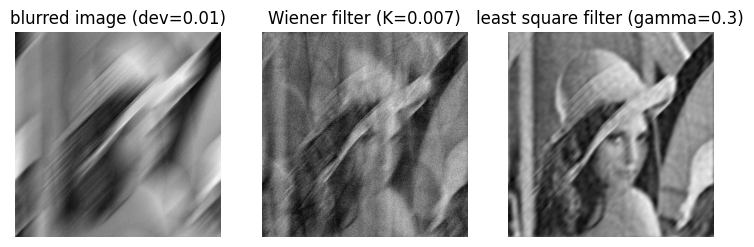

In [169]:
imgWienerFilter = wienerFilter(imgBlurNoisy, PSF, scale, K=0.007)  
imgLSFilter = leastSquareFilter(imgBlurNoisy, PSF, scale, gamma=0.3)  

plt.figure(figsize=(9, 7))
plt.subplot(231), plt.title("blurred image (dev=0.01)"), plt.axis('off'), plt.imshow(imgBlurNoisy, 'gray')
plt.subplot(232), plt.title("Wiener filter (K=0.007)"), plt.axis('off'), plt.imshow(imgWienerFilter, 'gray')
plt.subplot(233), plt.title("least square filter (gamma=0.3)"), plt.axis('off'), plt.imshow(imgLSFilter, 'gray')




- Conclusão
Podemos notar que o filtro dos mínimos quadrados foi melhor que o Wiener. Para o filtro dos mínimos quadrados quanto maior o valor a partir de gamma=0.01 melhor ficou o filtro até gamma=0.2, enquanto para o filtro Wiener quanto menor o valor a partir de k=0.01 melhor ficou a imagem até k=0.007